In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/캡스톤/거시경제및커피가격통합데이터.csv")

In [ ]:
import numpy as np

In [ ]:
df['abs_return'] = df['Coffee_Price_Return'].abs()
df["log_return"] = np.log(df["Coffee_Price"]) - np.log(df["Coffee_Price"].shift(1))
df["target_volatility_14d"] = df["log_return"].rolling(window=14).std().shift(-13)
# 5일, 10일 변동성 (rolling std)
df['volatility_5d'] = df['Coffee_Price_Return'].rolling(window=5).std()
df['volatility_10d'] = df['Coffee_Price_Return'].rolling(window=10).std()

# 5일 평균 수익률
df['momentum_5d'] = df['Coffee_Price'] - df['Coffee_Price'].shift(5)

# Bollinger Band Width (상대 변동성)
rolling_mean = df['Coffee_Price'].rolling(window=20).mean()
rolling_std = df['Coffee_Price'].rolling(window=20).std()
df['bollinger_width'] = (2 * rolling_std) / rolling_mean

# Return Z-score (비정상 변동 탐지)
df['return_zscore'] = (df['Coffee_Price_Return'] - df['Coffee_Price_Return'].rolling(20).mean()) / \
                       (df['Coffee_Price_Return'].rolling(20).std() + 1e-6)

df['momentum_1d'] = df['Coffee_Price'].diff(1)
df['momentum_3d'] = df['Coffee_Price'].diff(3)
df['volatility_ratio'] = df['volatility_5d'] / df['volatility_10d']

In [ ]:
df["recent_spike"] = (df["log_return"].rolling(3).max() - df["log_return"].rolling(3).min()).shift(1)
df["high_low_range_5d"] = (df["Coffee_Price"].rolling(5).max() - df["Coffee_Price"].rolling(5).min()) / df["Coffee_Price"].rolling(5).mean()
df["true_range"] = df["Coffee_Price"].diff().abs()
df["atr_5d"] = df["true_range"].rolling(window=5).mean()

In [ ]:
we = pd.read_csv("/content/drive/MyDrive/캡스톤/비수확기평균커피가격통합데이터.csv")

In [ ]:
we.drop(columns=['Coffee_Price', 'Coffee_Price_Return','Crude_Oil_Price','USD_KRW','USD_BRL','USD_COP'], inplace=True)

In [ ]:
df = pd.merge(df, we, on='Date', how='left')

In [ ]:
df = df.dropna()

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [ ]:
n = len(df)
train_size = int(n * 0.9)

train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

return_train = train_df["Coffee_Price_Return"].copy()
return_test = test_df["Coffee_Price_Return"].copy()


log_return_train = train_df["log_return"].copy()
log_return_test = test_df["log_return"].copy()

# target_train = train_df["target_volatility_14d"].copy()
# target_test = test_df["target_volatility_14d"].copy()

scaler_seq = MinMaxScaler()
train_df = pd.DataFrame(scaler_seq.fit_transform(train_df),
                        columns=train_df.columns,
                        index=train_df.index)

test_df = pd.DataFrame(scaler_seq.transform(test_df),
                        columns=test_df.columns,
                        index=test_df.index)

train_df["Coffee_Price_Return"] = return_train
test_df["Coffee_Price_Return"] = return_test

train_df["log_return"] = log_return_train
test_df["log_return"] = log_return_test

# train_df["target_volatility_14d"] = target_train
# test_df["target_volatility_14d"] = target_test

In [ ]:
print("Train target min:", train_df['target_volatility_14d'].min())
print("Train target max:", train_df['target_volatility_14d'].max())
print("Test target min:", test_df['target_volatility_14d'].min())
print("Test target max:", test_df['target_volatility_14d'].max())

Train target min: 0.0
Train target max: 1.0
Test target min: 0.07562532692313825
Test target max: 0.5482588566204503


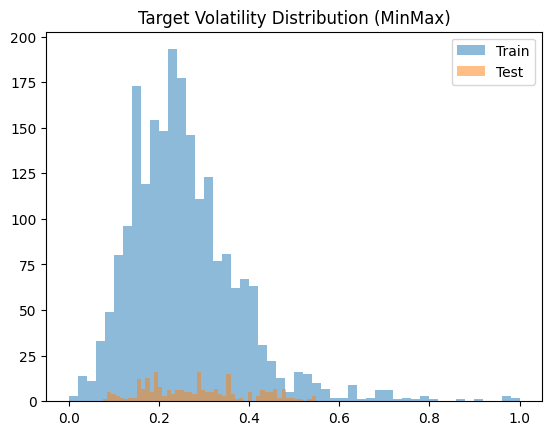

In [ ]:
import matplotlib.pyplot as plt

plt.hist(train_df["target_volatility_14d"], bins=50, alpha=0.5, label='Train')
plt.hist(test_df["target_volatility_14d"], bins=50, alpha=0.5, label='Test')
plt.legend()
plt.title("Target Volatility Distribution (MinMax)")
plt.show()

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset

class MultiStepTimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, window_size, step, static_feat_idx):
        self.data = []
        self.labels = []
        self.static_feats = []

        self.seq_feat_idx = [i for i in range(X.shape[1]) if i not in static_feat_idx]

        for i in range(0, len(X) - window_size, step):
            x_seq = X[i:i+window_size, self.seq_feat_idx]         # (T, D_seq)
            x_static = X[i, static_feat_idx]                      # (D_static,)
            y_target = y[i + window_size]                         # 미래 14일 변동성 (미리 shift(-13) 해둔 상태)

            if np.isnan(y_target):  # 결측치 제거
                continue

            self.data.append(x_seq)
            self.static_feats.append(x_static)
            self.labels.append(y_target)

        self.data = np.array(self.data)
        self.static_feats = np.array(self.static_feats)
        self.labels = np.array(self.labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x_seq = torch.tensor(self.data[idx], dtype=torch.float32)
        x_static = torch.tensor(self.static_feats[idx], dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.float32)  # (scalar)
        return x_seq, x_static, y

In [ ]:
X_train = train_df.values
target_col = "target_volatility_14d"
y_train = train_df[target_col].values

X_test = test_df.values
y_test = test_df[target_col].values

In [ ]:
data_window = 100  # 최근 데이터를 입력으로 사용
step = 1  # 단위로 샘플링

In [58]:
static_feat_idx = list(range(X_train.shape[1] - 9, X_train.shape[1]))

train_dataset = MultiStepTimeSeriesDataset(X_train, y_train, data_window, step, static_feat_idx)
test_dataset = MultiStepTimeSeriesDataset(X_test, y_test, data_window, step, static_feat_idx)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

LSTM 입력을 위해 3D 배열로 변경

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
pip install entmax

In [ ]:
def compute_attention_entropy(attn_weights):
    eps = 1e-8
    entropy = -torch.sum(attn_weights * torch.log(attn_weights + eps), dim=1)  # (B,)
    return entropy.mean().item()

In [ ]:
from entmax import Entmax15

class EntmaxAttention(nn.Module):
    def __init__(self, hidden_size, attn_dim=128):
        super().__init__()
        self.score_layer = nn.Sequential(
            nn.Linear(hidden_size, attn_dim),
            nn.Tanh(),
            nn.Linear(attn_dim, 1)
        )
        self.entmax = Entmax15(dim=1)

    def forward(self, lstm_output):
        # lstm_output: (B, T, H)
        scores = self.score_layer(lstm_output).squeeze(-1)  # (B, T)
        weights = self.entmax(scores)  # sparse attention weights
        context = torch.sum(lstm_output * weights.unsqueeze(-1), dim=1)  # (B, H)
        return context, weights

In [ ]:
class AttentionLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=1, dropout=0.3, static_feat_dim=9):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )

        self.attention = EntmaxAttention(hidden_size)

        self.gate = nn.Sequential(
            nn.Linear(hidden_size * 2, 1),
            nn.Sigmoid()
        )

        # 정적 피처 인코더 추가
        self.static_encoder = nn.Sequential(
            nn.Linear(static_feat_dim, 32),
            nn.ReLU(),
            nn.LayerNorm(32),
            nn.Dropout(0.2),
            nn.Linear(32, 64),
            nn.ReLU()
        )

        # FC 입력 차원 변경: fused(H) + static_encoded(64)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size + 64, hidden_size * 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size * 2, hidden_size * 2),
            nn.ReLU(),
            nn.Linear(hidden_size * 2, 1)
        )

    def forward(self, x_seq, x_static, hidden_states=None):
        batch_size = x_seq.size(0)

        if hidden_states is None:
            h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x_seq.device)
            c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x_seq.device)
            hidden_states = (h0, c0)

        lstm_out, _ = self.lstm(x_seq, hidden_states)

        if self.training:
            lstm_out = lstm_out + 0.05 * torch.randn_like(lstm_out)

        context, attn_weights = self.attention(lstm_out)
        last_hidden = lstm_out[:, -1, :]
        combined = torch.cat([context, last_hidden], dim=1)
        alpha = self.gate(combined)
        fused = alpha * context + (1 - alpha) * last_hidden

        # 정적 피처 인코딩 및 결합
        static_encoded = self.static_encoder(x_static)  # (B, 64)
        fused_with_static = torch.cat([fused, static_encoded], dim=1)  # (B, H+64)

        out = self.fc(fused_with_static).squeeze(-1)
        return out, attn_weights

#### 기본 학습 모델

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [52]:
def weighted_mse_loss(y_pred, y_true, temp=5.0):
    # 개별 loss 계산: (B,)
    sample_losses = (y_pred - y_true) ** 2

    # softmax 기반 가중치: 큰 loss에 더 높은 weight
    weights = torch.softmax(sample_losses * temp, dim=0)  # temp 높을수록 sharpen
    weighted_loss = torch.sum(weights * sample_losses)

    return weighted_loss

In [55]:
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

X_all = train_df.values
y_all = train_df[target_col].values

static_feat_idx = list(range(X_all.shape[1] - 9, X_all.shape[1]))
tscv = TimeSeriesSplit(n_splits=5)

fold_results = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_all)):
    print(f"\n===== Fold {fold + 1} =====")

    X_train_fold = X_all[train_idx]
    y_train_fold = y_all[train_idx]

    X_val_fold = X_all[val_idx]
    y_val_fold = y_all[val_idx]

    train_dataset = MultiStepTimeSeriesDataset(
        X_train_fold, y_train_fold,
        window_size=data_window,
        step=step,
        static_feat_idx=static_feat_idx
    )
    val_dataset = MultiStepTimeSeriesDataset(
        X_val_fold, y_val_fold,
        window_size=data_window,
        step=step,
        static_feat_idx=static_feat_idx
    )

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

    model = AttentionLSTMModel(
        input_size=X_all.shape[1] - 9,
        static_feat_dim=9
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

    for epoch in range(35):
        model.train()
        for x_seq, x_static, y in train_loader:
            x_seq, x_static, y = x_seq.to(device), x_static.to(device), y.to(device)

            optimizer.zero_grad()
            y_pred, _ = model(x_seq, x_static)
            # weighted MSE 적용
            loss = weighted_mse_loss(y_pred, y, temp=5.0)
            loss.backward()
            optimizer.step()

        # Validation 평가 (여기는 일반 MSE로 측정)
        model.eval()
        val_losses = []
        with torch.no_grad():
            for x_seq, x_static, y in val_loader:
                x_seq, x_static, y = x_seq.to(device), x_static.to(device), y.to(device)
                y_pred, _ = model(x_seq, x_static)
                val_loss = torch.mean((y_pred - y) ** 2).item()
                val_losses.append(val_loss)
        avg_val_loss = np.mean(val_losses)
        print(f"Epoch {epoch+1}, Val Loss: {avg_val_loss:.4f}")

    fold_results.append(avg_val_loss)

print("\nFold별 평균 Loss:", fold_results)
print("전체 평균 Validation Loss:", np.mean(fold_results))


===== Fold 1 =====
Epoch 1, Val Loss: 0.0130
Epoch 2, Val Loss: 0.0070
Epoch 3, Val Loss: 0.0096
Epoch 4, Val Loss: 0.0072
Epoch 5, Val Loss: 0.0064
Epoch 6, Val Loss: 0.0073
Epoch 7, Val Loss: 0.0079
Epoch 8, Val Loss: 0.0072
Epoch 9, Val Loss: 0.0073
Epoch 10, Val Loss: 0.0062
Epoch 11, Val Loss: 0.0065
Epoch 12, Val Loss: 0.0066
Epoch 13, Val Loss: 0.0058
Epoch 14, Val Loss: 0.0062
Epoch 15, Val Loss: 0.0079
Epoch 16, Val Loss: 0.0061
Epoch 17, Val Loss: 0.0067
Epoch 18, Val Loss: 0.0085
Epoch 19, Val Loss: 0.0063
Epoch 20, Val Loss: 0.0063
Epoch 21, Val Loss: 0.0075
Epoch 22, Val Loss: 0.0068
Epoch 23, Val Loss: 0.0062
Epoch 24, Val Loss: 0.0066
Epoch 25, Val Loss: 0.0063
Epoch 26, Val Loss: 0.0059
Epoch 27, Val Loss: 0.0064
Epoch 28, Val Loss: 0.0092
Epoch 29, Val Loss: 0.0074
Epoch 30, Val Loss: 0.0062
Epoch 31, Val Loss: 0.0062
Epoch 32, Val Loss: 0.0075
Epoch 33, Val Loss: 0.0065
Epoch 34, Val Loss: 0.0071
Epoch 35, Val Loss: 0.0061

===== Fold 2 =====
Epoch 1, Val Loss: 0.033

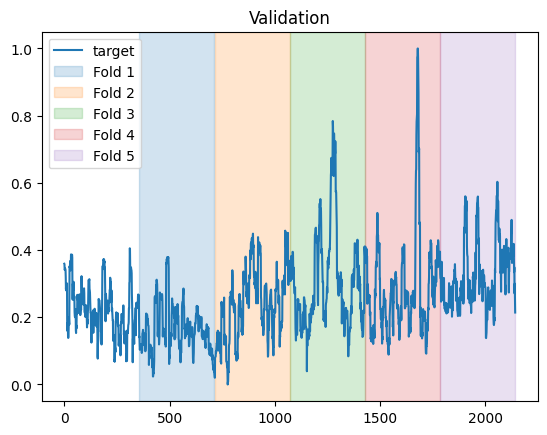

In [56]:
import matplotlib.pyplot as plt

plt.plot(y_all, label="target")
for i, (_, val_idx) in enumerate(tscv.split(X_all)):
    plt.axvspan(val_idx[0], val_idx[-1], color=f"C{i}", alpha=0.2, label=f"Fold {i+1}")
plt.legend()
plt.title("Validation")
plt.show()

In [64]:
x_seq, x_static, _ = train_dataset[0]

input_size = x_seq.shape[1]
model = AttentionLSTMModel(input_size=input_size, static_feat_dim=9).to(device)
base_criterion = nn.MSELoss()


optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

In [63]:
# ✅ 최종 학습 루프 (weighted loss 포함)
for epoch in range(50):  # ← epoch 수 늘림
    model.train()
    epoch_loss = 0.0

    for x_seq, x_static, y in train_loader:
        x_seq, x_static, y = x_seq.to(device), x_static.to(device), y.to(device)

        optimizer.zero_grad()
        y_pred, _ = model(x_seq, x_static)
        loss = weighted_mse_loss(y_pred, y, temp=5.0)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    print(f"[Final Training] Epoch {epoch+1}, Train Loss: {avg_loss:.4f}")

[Final Training] Epoch 1, Train Loss: 0.0415
[Final Training] Epoch 2, Train Loss: 0.0214
[Final Training] Epoch 3, Train Loss: 0.0200
[Final Training] Epoch 4, Train Loss: 0.0219
[Final Training] Epoch 5, Train Loss: 0.0200
[Final Training] Epoch 6, Train Loss: 0.0136
[Final Training] Epoch 7, Train Loss: 0.0104
[Final Training] Epoch 8, Train Loss: 0.0081
[Final Training] Epoch 9, Train Loss: 0.0068
[Final Training] Epoch 10, Train Loss: 0.0047
[Final Training] Epoch 11, Train Loss: 0.0036
[Final Training] Epoch 12, Train Loss: 0.0032
[Final Training] Epoch 13, Train Loss: 0.0035
[Final Training] Epoch 14, Train Loss: 0.0028
[Final Training] Epoch 15, Train Loss: 0.0024
[Final Training] Epoch 16, Train Loss: 0.0025
[Final Training] Epoch 17, Train Loss: 0.0024
[Final Training] Epoch 18, Train Loss: 0.0023
[Final Training] Epoch 19, Train Loss: 0.0024
[Final Training] Epoch 20, Train Loss: 0.0021
[Final Training] Epoch 21, Train Loss: 0.0020
[Final Training] Epoch 22, Train Loss: 0.00

In [65]:
num_epochs = 50

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    all_train_preds = []
    all_train_targets = []

    for x_seq, x_static, y_batch in train_loader:
        x_seq, x_static, y_batch = x_seq.to(device), x_static.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred, _ = model(x_seq, x_static)  # y_pred: (B,)

        loss = base_criterion(y_pred, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        optimizer.step()

        epoch_loss += loss.item()
        all_train_preds.append(y_pred.detach().cpu())
        all_train_targets.append(y_batch.detach().cpu())

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # 통계 출력
    all_train_preds_tensor = torch.cat(all_train_preds, dim=0)
    all_train_targets_tensor = torch.cat(all_train_targets, dim=0)
    y_pred_mean = all_train_preds_tensor.mean().item()
    y_pred_std = all_train_preds_tensor.std().item()
    y_true_mean = all_train_targets_tensor.mean().item()
    y_true_std = all_train_targets_tensor.std().item()

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for x_test_seq, x_test_static, y_test in test_loader:
            x_test_seq, x_test_static, y_test = x_test_seq.to(device), x_test_static.to(device), y_test.to(device)
            y_test_pred, _ = model(x_test_seq, x_test_static)

            test_loss += base_criterion(y_test_pred, y_test).item()

    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    scheduler.step(avg_test_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f} | "
          f"y_pred mean: {y_pred_mean:.4f}, std: {y_pred_std:.4f} | "
          f"y_true mean: {y_true_mean:.4f}, std: {y_true_std:.4f}")

Epoch [1/50] | Train Loss: 0.0169 | Test Loss: 0.0199 | y_pred mean: 0.2496, std: 0.0752 | y_true mean: 0.2570, std: 0.1255
Epoch [2/50] | Train Loss: 0.0128 | Test Loss: 0.0206 | y_pred mean: 0.2551, std: 0.0635 | y_true mean: 0.2570, std: 0.1255
Epoch [3/50] | Train Loss: 0.0125 | Test Loss: 0.0174 | y_pred mean: 0.2556, std: 0.0676 | y_true mean: 0.2570, std: 0.1255
Epoch [4/50] | Train Loss: 0.0108 | Test Loss: 0.0139 | y_pred mean: 0.2556, std: 0.0715 | y_true mean: 0.2570, std: 0.1255
Epoch [5/50] | Train Loss: 0.0084 | Test Loss: 0.0122 | y_pred mean: 0.2562, std: 0.0853 | y_true mean: 0.2570, std: 0.1255
Epoch [6/50] | Train Loss: 0.0051 | Test Loss: 0.0050 | y_pred mean: 0.2571, std: 0.1037 | y_true mean: 0.2570, std: 0.1255
Epoch [7/50] | Train Loss: 0.0034 | Test Loss: 0.0056 | y_pred mean: 0.2567, std: 0.1128 | y_true mean: 0.2570, std: 0.1255
Epoch [8/50] | Train Loss: 0.0031 | Test Loss: 0.0037 | y_pred mean: 0.2562, std: 0.1130 | y_true mean: 0.2570, std: 0.1255
Epoch [9

In [66]:
with torch.no_grad():
    # 1개 샘플 선택 후 배치 차원 유지
    sample_seq, sample_static, _ = train_dataset[0]
    sample_seq = sample_seq.unsqueeze(0).to(device)      # (1, T, D_seq)
    sample_static = sample_static.unsqueeze(0).to(device)  # (1, D_static)

    _, attn_weights = model(sample_seq, sample_static)
    print("Attention std:", attn_weights.std().item())
    print("Attention weights:", attn_weights)

Attention std: 0.00043036325951106846
Attention weights: tensor([[0.0097, 0.0099, 0.0097, 0.0097, 0.0096, 0.0096, 0.0096, 0.0097, 0.0097,
         0.0099, 0.0098, 0.0098, 0.0098, 0.0102, 0.0103, 0.0104, 0.0104, 0.0106,
         0.0106, 0.0107, 0.0108, 0.0107, 0.0107, 0.0107, 0.0106, 0.0103, 0.0099,
         0.0095, 0.0093, 0.0093, 0.0093, 0.0093, 0.0092, 0.0091, 0.0091, 0.0091,
         0.0089, 0.0088, 0.0094, 0.0096, 0.0097, 0.0097, 0.0096, 0.0095, 0.0095,
         0.0097, 0.0098, 0.0098, 0.0100, 0.0102, 0.0102, 0.0102, 0.0103, 0.0104,
         0.0105, 0.0105, 0.0106, 0.0107, 0.0106, 0.0104, 0.0103, 0.0104, 0.0103,
         0.0102, 0.0100, 0.0099, 0.0100, 0.0102, 0.0105, 0.0104, 0.0104, 0.0101,
         0.0101, 0.0100, 0.0100, 0.0101, 0.0101, 0.0101, 0.0101, 0.0102, 0.0101,
         0.0101, 0.0101, 0.0101, 0.0100, 0.0099, 0.0098, 0.0099, 0.0100, 0.0101,
         0.0102, 0.0102, 0.0101, 0.0100, 0.0099, 0.0101, 0.0101, 0.0101, 0.0101,
         0.0104]], device='cuda:0')


attention이 특정 지점을 더 많이 보는 것이 아니라 전반적으로 같은 수치로 보고있는 문제가 여전히 있음 >> 더 sharpen할 수 있도록 수정 필요 !!!

In [67]:
input_seq1, static_feat1, y_true1 = test_dataset[0]
input_seq2, static_feat2, y_true2 = test_dataset[10]

# 배치 차원 추가 (B=1)
input_seq1 = input_seq1.unsqueeze(0).to(device)
input_seq2 = input_seq2.unsqueeze(0).to(device)
static_feat1 = static_feat1.unsqueeze(0).to(device)
static_feat2 = static_feat2.unsqueeze(0).to(device)

# 모델 호출 시 두 인자 모두 전달
out1, _ = model(input_seq1, static_feat1)
out2, _ = model(input_seq2, static_feat2)

print("Prediction difference:", torch.norm(out1 - out2).item())

Prediction difference: 0.12383770942687988


In [70]:
with torch.no_grad():
    out, _ = model.lstm(sample_seq)
    std_across_time = out.std(dim=1).mean().item()
    print("LSTM output std (across time steps):", std_across_time)

LSTM output std (across time steps): 0.02203509584069252


In [71]:
print("y_pred mean:", y_pred.mean().item())
print("y_batch mean:", y_batch.mean().item())

y_pred mean: 0.24098342657089233
y_batch mean: 0.23543958365917206


In [78]:
predictions = []
true_values = []
date_ranges = []
future_target = 14

target_col = "target_volatility_14d"
target_idx = test_df.columns.get_loc(target_col)

with torch.no_grad():
    for batch_idx, (x_seq, x_static, y_true) in enumerate(test_loader):
        x_seq = x_seq.to(device)
        x_static = x_static.to(device)

        y_pred, _ = model(x_seq, x_static)               # (B,)
        y_pred = y_pred.squeeze(-1).cpu().numpy()        # (B,)
        y_true = y_true.cpu().numpy()                    # (B,)

        for i in range(x_seq.size(0)):
            global_idx = batch_idx * test_loader.batch_size + i
            target_idx_in_df = global_idx * step + data_window + future_target - 1

            if target_idx_in_df >= len(test_df):
                continue

            dummy_pred = np.zeros((1, test_df.shape[1]))
            dummy_true = np.zeros((1, test_df.shape[1]))

            dummy_pred[0, target_idx] = y_pred[i]
            dummy_true[0, target_idx] = y_true[i]

            # 역정규화
            y_pred_inv = scaler_seq.inverse_transform(dummy_pred)[0, target_idx]
            y_true_inv = scaler_seq.inverse_transform(dummy_true)[0, target_idx]

            predictions.append(y_pred_inv)
            true_values.append(y_true_inv)
            date_ranges.append(test_df.index[target_idx_in_df])

In [79]:
print("y_pred std:", np.std(predictions))
print("y_true std:", np.std(true_values))

y_pred std: 0.004335628388340252
y_true std: 0.0059909263026603115


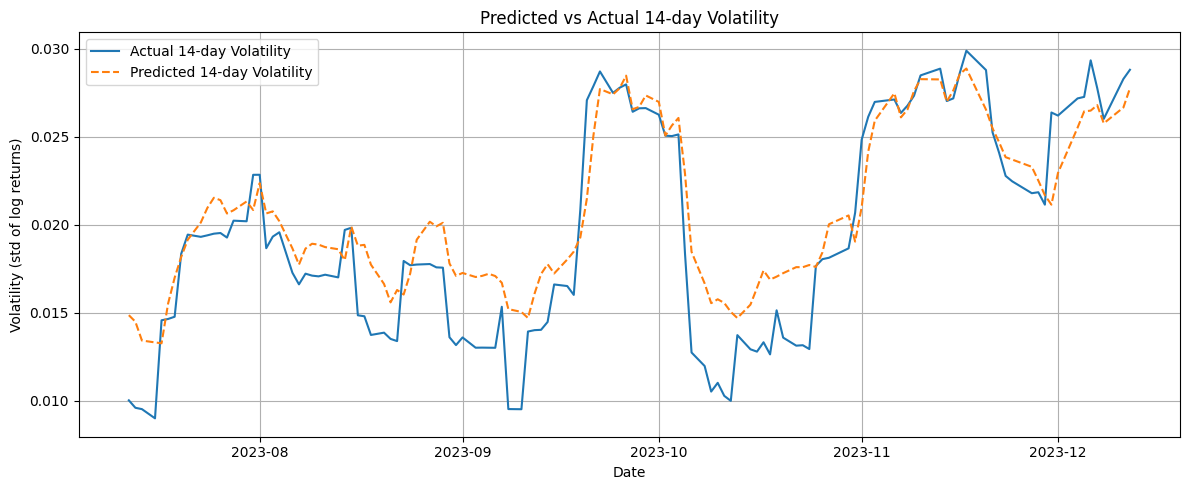

In [80]:
import matplotlib.pyplot as plt
import pandas as pd

pred_series = pd.Series(predictions, index=date_ranges)
true_series = pd.Series(true_values, index=date_ranges)

plt.figure(figsize=(12, 5))
plt.plot(true_series.sort_index(), label='Actual 14-day Volatility')
plt.plot(pred_series.sort_index(), label='Predicted 14-day Volatility', linestyle='--')
plt.title("Predicted vs Actual 14-day Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility (std of log returns)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [84]:
df_preds = pd.DataFrame({
    "date": date_ranges,
    "pred_vol": predictions,
    "true_vol": true_values
})

# 해당 날짜의 실제 가격 정보 추가
df_preds["price"] = df.loc[df_preds["date"], "Coffee_Price"].values

# 인덱스를 날짜로 지정
df_preds.set_index("date", inplace=True)

In [85]:
df_preds

,pred_vol,true_vol,price
date,,,
2023-07-12,0.014854,0.010015,158.750000
2023-07-13,0.014484,0.009592,159.350006
2023-07-14,0.013414,0.009515,161.949997
2023-07-16,0.013306,0.008991,161.949997
2023-07-17,0.013256,0.014565,154.750000
...,...,...,...
2023-12-06,0.026480,0.029339,185.250000
2023-12-07,0.026793,0.027759,185.500000
2023-12-08,0.025757,0.026011,185.149994


In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# ① 예측 변동성 기반 가격 시뮬레이션 함수
def simulate_price_curve(start_date, predicted_volatility, base_price, num_days=14):
    np.random.seed(0)
    simulated_returns = np.random.normal(loc=0.0, scale=predicted_volatility, size=num_days)
    prices = base_price * np.exp(np.cumsum(simulated_returns))
    date_range = pd.date_range(start=start_date, periods=num_days)
    return pd.Series(prices, index=date_range)

def plot_price_simulation_curve(df, index=0):
    date = df.index[index]
    vol = df.iloc[index]["pred_vol"]
    price = df.iloc[index]["price"]
    sim_curve = simulate_price_curve(date, vol, price)
    plt.figure(figsize=(10, 4))
    plt.plot(sim_curve.index, sim_curve.values, label='Simulated Price')
    plt.title(f"Simulated Price from {date.date()} (vol={vol:.4f})")
    plt.xlabel("Date")
    plt.ylabel("Simulated Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

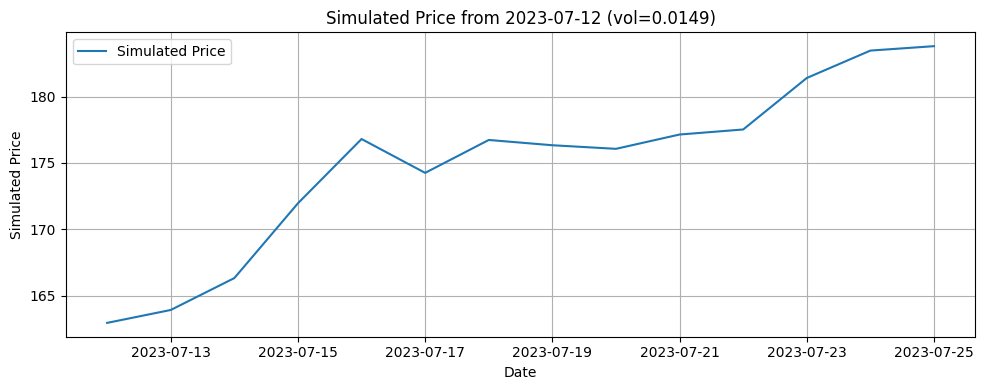

In [87]:
plot_price_simulation_curve(df_preds, index=0)

In [88]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_pred = np.array(predictions)
y_true = np.array(true_values)

# RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# MAE (Mean Absolute Error)
mae = mean_absolute_error(y_true, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")

RMSE: 0.0027
MAE:  0.0021


일관되게 낮은 오차 내고있음